# 01. Learning LangGraph - Agent Executor

In [1]:
# !pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental

modified from https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/base.ipynb

In [1]:
# importing os module for environment variables
import os
# importing necessary functions from dotenv library
from dotenv import load_dotenv, dotenv_values
# loading variables from .env file
load_dotenv()

True

In [2]:
api_key = os.getenv('PRACTICE_KEY')
langchain_api_key = os.getenv('LANGCHAIN_KEY')

In [3]:
import os
# from google.colab import userdata

os.environ["OPENAI_API_KEY"] = api_key

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_01"

## Making the GraphState

In [4]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
   # The input string
   input: str
   # The list of previous messages in the conversation
   chat_history: list[BaseMessage]
   # The outcome of a given call to the agent
   # Needs `None` as a valid type, since this is what this will start as
   agent_outcome: Union[AgentAction, AgentFinish, None]
   # List of actions and corresponding observations
   # Here we annotate this with `operator.add` to indicate that operations to
   # this state should be ADDED to the existing values (not overwrite it)
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Custom Tools

**Tools**  

Tools are interfaces that an agent can use to interact with the world. They combine a few things:



1.   The name of the tool
2.   A description of what the tool is
3.   JSON schema of what the inputs to the tool are
4.   The function to call


Whether the result of a tool should be returned directly to the user

In [6]:
from langchain.tools import BaseTool, StructuredTool, Tool, tool

In [7]:
import random

@tool("lower_case", return_direct=True)
def to_lower_case(input:str) -> str:
  """Returns the input as all lower case."""
  return input.lower()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100."""
    return random.randint(0, 100)

tools = [to_lower_case,random_number_maker]

In [8]:
random_number_maker.run('random')

85

In [9]:
to_lower_case.run('BHAIYA SINGH')

'bhaiya singh'

## Agent - with new create_open_ai

In [10]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm,
                                               tools,
                                               prompt)

In [11]:
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')), MessagesPlace

In [12]:
prompt.get_prompts()

[ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')), MessagesPlac

In [13]:
inputs = {"input": "give me a random number and then write in words and make it lower case.",
          "chat_history": [],
          "intermediate_steps":[]}

agent_outcome = agent_runnable.invoke(inputs)

In [14]:
agent_outcome

AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call'}, id='run-9cbd0114-2e95-424f-9e5d-e9d4cf4b753d-0')])

In [15]:
type(agent_runnable)

langchain_core.runnables.base.RunnableSequence

## Nodes

In [16]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

tool_executor = ToolExecutor(tools)

In [17]:
# Define the agent/graph
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data['agent_outcome']
    # Execute the tool
    output = tool_executor.invoke(agent_action)
    print(f"The agent action is {agent_action}")
    print(f"The tool result is: {output}")
    # Return the output
    return {"intermediate_steps": [(agent_action, str(output))]}

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data['agent_outcome'], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

## Define the graph

In [18]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

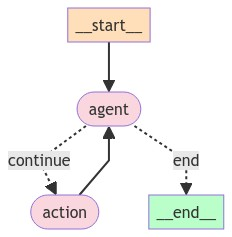

In [19]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
workflow.branches

defaultdict(dict,
            {'agent': {'should_continue': Branch(path=should_continue(recurse=True), ends={'continue': 'action', 'end': '__end__'}, then=None)}})

In [21]:
workflow.nodes, workflow.edges

({'agent': agent(recurse=True), 'action': action(recurse=True)},
 {('__start__', 'agent'), ('action', 'agent')})

In [22]:
workflow.channels #['intermediate_steps']

{'input': <langgraph.channels.last_value.LastValue at 0x201be91ac20>,
 'chat_history': <langgraph.channels.last_value.LastValue at 0x201bea6bb80>,
 'agent_outcome': <langgraph.channels.last_value.LastValue at 0x201bea6bf40>,
 'intermediate_steps': <langgraph.channels.binop.BinaryOperatorAggregate at 0x201beaac7c0>}

In [23]:
inputs = {"input": "give me a random number and then write in words and make it lower case.", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call'}, id='run-378a1711-7b19-4a61-a8ec-9546a108638c-0')])}
----
The agent action is tool='random_number' tool_input={'input': 'random'} log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call'}, id='run-378a1711-7b19-4a61-a8ec-9546a108638c-0')]
The tool result is: 90
{'intermediate_steps': [(AgentActionMessageLog(tool='random_number', tool_input={'input': 'random'}, log="\nInvoking: `random_number` with `{'input': 'random'}`\n\n\n", message_log=[AIMessage(c

In [ ]:
inputs = {"input": "give me a random number and then write in words and make it lower case", "chat_history": []}

output = app.invoke(inputs)

The agent action is tool='random_number' tool_input={'input': 'random number'} log="\nInvoking: `random_number` with `{'input': 'random number'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random number"}', 'name': 'random_number'}})]
The tool result is: 60
The agent action is tool='lower_case' tool_input={'input': 'SIXTY'} log="\nInvoking: `lower_case` with `{'input': 'SIXTY'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"SIXTY"}', 'name': 'lower_case'}})]
The tool result is: sixty


In [ ]:
output.get("agent_outcome").return_values['output']

'The random number is 60, and in words, it is "sixty", all in lower case.'

In [ ]:
output.get("intermediate_steps")

[(AgentActionMessageLog(tool='random_number', tool_input={'input': 'random number'}, log="\nInvoking: `random_number` with `{'input': 'random number'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"random number"}', 'name': 'random_number'}})]),
  '60'),
 (AgentActionMessageLog(tool='lower_case', tool_input={'input': 'SIXTY'}, log="\nInvoking: `lower_case` with `{'input': 'SIXTY'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"SIXTY"}', 'name': 'lower_case'}})]),
  'sixty')]

In [ ]:
inputs = {"input": "does it get cold in SF in Jan?", "chat_history": []}

output = app.invoke(inputs)

In [ ]:
output.get("agent_outcome").return_values['output']


"Yes, San Francisco can experience cold weather in January. The average temperature in January ranges from 45°F to 57°F (7°C to 14°C), so it's a good idea to pack some warm clothing if you plan to visit San Francisco in January."

In [ ]:
output.get("intermediate_steps")

[]